#### Convert files from Thermo

ThermoRawFileParser https://github.com/compomics/ThermoRawFileParser

Convert profile MS1 data from profile to centroid (MS1 and MS2) mzml

In [ ]:
!mono resources/ThermoRawFileParser/ThermoRawFileParser.exe -d="data/raw/" -o="results/interim"

Import libraries:

In [ ]:
import sys
import pandas as pd
import numpy as np
import os
import glob
sys.path.insert(0, '/home/eeko/openms-develop/openms-build/pyOpenMS')
from pyopenms import *

# `Preprocessing workflow`

#### The preprocessing workflow consists of five steps:

#### `1) PrecursorCorrection` (To the "highest intensity MS1 peak")

This algorithm is used directly after the file introduction, in order to correct any wrong MS1 precursor annotation - this means it will correct the precursor m/z in a given mass range (e.g. 0.1 Da) and then use the highest intensity peak as the precursor. We assume that, in the given mass window, the precursor with the hightest intensity was actually fragmented (top-n method), which is a method used by default in the Thermo Orbitrap instrument (Center for Biosustainability).


###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html//classOpenMS_1_1PrecursorCorrection.html#a8acf85ba8b9f249de0369bb083355982 

In [ ]:
path= "results/interim"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_original_files = glob.glob('results/interim/*.mzML')
    
for filename in input_original_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    delta_mzs= []
    mzs = []
    rts= []
    PrecursorCorrection.correctToHighestIntensityMS1Peak(exp, 100.0, True, delta_mzs, mzs, rts)
    mzmlfile_path = os.path.join(os.path.dirname(filename), 'PCpeak_' + os.path.basename(filename))
    MzMLFile().store(mzmlfile_path, exp)

#### `2) Mass trace detection`

A mass trace extraction method that gathers peaks similar in m/z and moving along retention time.
Peaks of a MSExperiment are sorted by their intensity and stored in a list of potential chromatographic apex positions. Only peaks that are above the noise threshold (user-defined) are analyzed and only peaks that are n times above this minimal threshold are considered as apices. This saves computational resources and decreases the noise in the resulting output.
Starting with these, mass traces are extended in- and decreasingly in retention time. During this extension phase, the centroid m/z is computed on-line as an intensity-weighted mean of peaks.
The extension phase ends when either the frequency of gathered peaks drops below a threshold (min_sample_rate, see MassTraceDetection parameters) or when the number of missed scans exceeds a threshold (trace_termination_outliers, see MassTraceDetection parameters).
Finally, only mass traces that pass a filter (a certain minimal and maximal length as well as having the minimal sample rate criterion fulfilled) get added to the result.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MassTraceDetection.html#abff6e392ce6da7af8f083397494a7971



#### `3) Elution peak detection`

Extracts chromatographic peaks from a mass trace.
Mass traces may consist of several consecutively (partly overlapping) eluting peaks, e.g., stemming from (almost) isobaric compounds that are separated by retention time. Especially in metabolomics, isomeric compounds with exactly the same mass but different retentional behaviour may still be contained in the same mass trace. This method first applies smoothing on the mass trace's intensities, then detects local minima/maxima in order to separate the chromatographic peaks from each other. Depending on the "width_filtering" parameters, mass traces are filtered by length in seconds ("fixed" filter) or by quantile.

This method in other words is "deconvolution".

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1ElutionPeakDetection.htmldetails


#### `4) Feature detection`

FeatureFinderMetabo assembles metabolite features from singleton mass traces.
Mass traces alone would allow for further analysis such as metabolite ID or statistical evaluation. However, in general, monoisotopic mass traces are accompanied by satellite C13 peaks and thus may render the analysis more difficult. FeatureFinderMetabo fulfills a further data reduction step by assembling compatible mass traces to metabolite features (that is, all mass traces originating from one metabolite). To this end, multiple metabolite hypotheses are formulated and scored according to how well differences in RT (optional), m/z or intensity ratios match to those of theoretical isotope patterns.
If the raw data scans contain the scan polarity information, it is stored as meta value "scan_polarity" in the output file.
Mass trace clustering can be done using either 13C distances or a linear model (Kenar et al) – see parameter 'ffm:mz_scoring_13C'. Generally, for lipidomics, use 13C, since lipids contain a lot of 13C. For general metabolites, the linear model is usually more appropriate. To decide what is better, the total number of features can be used as indirect measure.
the lower(!) the better (since more mass traces are assembled into single features). Detailed information is stored in the featureXML output: it contains meta-values for each feature about the mass trace differences (inspectable via TOPPView). 
By default, the linear model is used.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1FeatureFindingMetabo.html

#### `5) Metabolite adduct decharger` 

For each peak, this algorithm reconstructs neutral masses by enumerating all possible adducts with matching charge. You can add the list of adduct files and database files for the algorithm to parse through.
With SIRIUS, an algorithm that is later used, you are only able to use singly charged adducts so charges higher than 1 are filtered out. 

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_MetaboliteAdductDecharger.html

In [ ]:
path= "results/features/interim"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_mzml_files = glob.glob('results/interim/PCpeak_*.mzML')

# 2) Mass trace detection

for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    mass_traces = []
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults()
    mtd_par.setValue("mass_error_ppm", 10.0) 
    mtd_par.setValue("noise_threshold_int", 1.0e04)
    mtd.setParameters(mtd_par)
    mtd.run(exp, mass_traces, 0)

# 3) Elution peak detection

    mass_traces_split = []
    mass_traces_final = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed")
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_split)
     
    if (epd.getParameters().getValue("width_filtering") == "auto"):
          epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
    else:
          mass_traces_final = mass_traces_split

# 4) Feature detection
  
    feature_map_FFM = FeatureMap()
    feat_chrom = []
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("isotope_filtering_model", "none")
    ffm_par.setValue("remove_single_traces", "true")
    ffm_par.setValue("mz_scoring_by_elements", "false")
    ffm_par.setValue("report_convex_hulls", "true")
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_final, feature_map_FFM, feat_chrom)
    feature_map_FFM.setUniqueIds()
    feature_map_FFM.setPrimaryMSRunPath([filename.encode()])  


# 5) Metabolite adduct decharger (MetaboliteFeatureDeconvolution)

    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts", [b"H:+:0.4",b"Na:+:0.2",b"NH4:+:0.2", b"H-1O-1:+:0.1", b"H-3O-2:+:0.1"])
    mdf_par.setValue("charge_min", 1, "Minimal possible charge")
    mdf_par.setValue("charge_max", 1, "Maximal possible charge")
    mdf_par.setValue("charge_span_max", 1)
    mdf_par.setValue("max_neutrals", 1)
    mfd.setParameters(mdf_par)
        
    feature_maps = FeatureMap()
    cons_map0 = ConsensusMap()
    cons_map1 = ConsensusMap()
    mfd.compute(feature_map_FFM, feature_maps, cons_map0, cons_map1)
    consensusfile = os.path.join("results", "", "features", "", "interim", "", 'MFD_' + os.path.basename(filename)[7:-5] +".consensusXML")
    ConsensusXMLFile().store(consensusfile, cons_map0)
    featurefile = os.path.join("results", "", "features", "", "interim", "", 'MFD_' + os.path.basename(filename)[7:-5] +".featureXML")
    FeatureXMLFile().store(featurefile, feature_maps)

#### Display the features in a dataframe

In [ ]:
input_feature_files = glob.glob('results/features/interim/*.featureXML')

for filename in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "features", "", 'features_' + os.path.basename(filename)[4:-10] +"csv")
    DF= DF.drop(columns="sequence")
    DF.to_csv(feature_csv)
    print(filename)
    display(DF)

Display the consensus XML as a dataframe, which is the file that represents the collapsed features (no charge)

In [ ]:
input_collapsed_features = glob.glob('results/features/interim/*.consensusXML')

for consensus in input_collapsed_features:
    fmap = ConsensusMap()
    ConsensusXMLFile().load(consensus, fmap)
    DF= fmap.get_df()
    DF= DF.drop(columns=["sequence", "quality", "charge"])
    print(consensus)
    display(DF)

## `Formula and structural predictions of the preprocessed data`

#### `1) PrecursorCorrection (To the "nearest feature”)`

This algorithm is used after feature detection, adduct grouping and even identification via accurate mass search. It basically allows the precursor correction on MS2 level. 

Which means that if there are MS2 spectra in my feature space which have been measured in isotope traces, it “corrects” the MS2 spectrum annotation to the monoisotopic trace. That is why you have a high mass deviation 100 pm, but 0.0 rt tolerance. So it basically corrects the MS2 to the feature centroid that can be found/mapped by SIRIUS::preprocessing later on.

Wrong assignment of the mono-isotopic mass for precursors are assumed:

1. if precursor_mz matches the mz of a non-monoisotopic feature mass trace and 
2. in the case that believe_charge is true: if feature_charge matches the precursor_charge In the case of wrong mono-isotopic assignment several options for correction are available: keep_original will create a copy of the precursor and tandem spectrum for the new mono-isotopic mass trace and retain the original one. all_matching_features does this not for only the closest feature but all features in a question.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1PrecursorCorrection.html

We need to preprocess again without convex hulls this time, otherwise the results from SIRIUS are incorrect

#### `2) (i) SIRIUS Adapter`
The SIRIUS function is optional and includes the SIRIUS Adapter Algorithm from the Boecher lab. 


The algorithm generates formula prediction from scores calculated from 1) MS2 fragmentation scores (ppm error + intensity) and 2) MS1 isotopic pattern scores.


It can only compute feautures that are singly charged. There is also a timeout for compounds (compound timeout so that it doesn't compute for longer than 100 seconds per feature, which normally happens with larger molecules).
        
>-sirius:compound_timeout <number>                    

>Maximal computation time in seconds for a single compound. 0 for an infinite amount of time. (default: '100' min: '0')

#### `2) (ii) CSI:FingerID`

The CSI_fingerID function is another algorithm from the Boecher lab, just like SIRIUS adapter and is using the formula predictions from SIRIUS, to search in structural libraries and predict the structure of each formula

If you replace: 
    
>out_csifingerid = os.path.join("results", "", "interim", "", "CSI", "", 'structures_' + os.path.basename(filename) +".mzTab")

with an empty string:

>out_csifingerid = ""
        
CSI:FingerID will be ignored and will not be computed.

###### Documentation: https://boecker-lab.github.io/docs.sirius.github.io/

###### Citation: Kai Dührkop, Huibin Shen, Marvin Meusel, Juho Rousu, and Sebastian Böcker, Searching molecular structure databases with tandem mass spectra using CSI:FingerID, PNAS October 13, 2015 112 (41) 12580-12585, https://doi.org/10.1073/pnas.1509788112

In [ ]:
path1= "results/formulas/interim"
isExist= os.path.exists(path1)
if not isExist:
    os.mkdir(path1)

path2= "results/structures/interim"
isExist= os.path.exists(path2)
if not isExist:
    os.mkdir(path2)

input_mzml_files = glob.glob('results/interim/PCpeak_*.mzML')

for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)

    mass_traces = []
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults()
    mtd_par.setValue("mass_error_ppm", 10.0) 
    mtd_par.setValue("noise_threshold_int", 1.0e04)
    mtd.setParameters(mtd_par)
    mtd.run(exp, mass_traces, 0)

    mass_traces_split = []
    mass_traces_final = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed")
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_split)
        
    if (epd.getParameters().getValue("width_filtering") == "auto"):
        epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
    else:
        mass_traces_final = mass_traces_split

    feature_map_FFM = FeatureMap()
    feat_chrom = []
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("isotope_filtering_model", "none")
    ffm_par.setValue("remove_single_traces", "false")
    ffm_par.setValue("mz_scoring_by_elements", "false")
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_final, feature_map_FFM, feat_chrom)
    feature_map_FFM.setUniqueIds()
    feature_map_FFM.setPrimaryMSRunPath([filename.encode()])

    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts",  [b"H:+:0.4",b"Na:+:0.2",b"NH4:+:0.2", b"H-1O-1:+:0.1", b"H-3O-2:+:0.1"])  
    mdf_par.setValue("charge_min", 1, "Minimal possible charge")
    mdf_par.setValue("charge_max", 1, "Maximal possible charge")
    mdf_par.setValue("charge_span_max", 1)
    mdf_par.setValue("max_neutrals", 1)
    mfd.setParameters(mdf_par)
    feature_map_DEC = FeatureMap()
    cons_map0 = ConsensusMap()
    cons_map1 = ConsensusMap()
    mfd.compute(feature_map_FFM, feature_map_DEC, cons_map0, cons_map1)
    
    featureinfo = os.path.join("results", "", "formulas", "", "interim", "", 'MFD_noconvexhulls_' + os.path.basename(filename)[:-5] + ".featureXML")
    FeatureXMLFile().store(featureinfo, feature_map_DEC)

    PrecursorCorrection.correctToNearestFeature(feature_map_DEC, exp, 0.0, 100.0, True, False, False, False, 3, 0)

    sirius_algo = SiriusAdapterAlgorithm()
    sirius_algo_par = sirius_algo.getDefaults()
    sirius_algo_par.setValue("preprocessing:filter_by_num_masstraces", 2) #Number of mass traces each feature has to have to be included
    sirius_algo_par.setValue("preprocessing:feature_only", "true") #Uses the feature information from in_featureinfo to reduce the search space to MS2
    sirius_algo_par.setValue("sirius:profile", "orbitrap")
    sirius_algo_par.setValue("sirius:db", "none")
    sirius_algo_par.setValue("sirius:ions_considered", "[M+H]+, [M-H2O+H]+, [M+Na]+, [M+NH4]+")
    sirius_algo_par.setValue("sirius:elements_enforced", "CHN[15]OS[4]") 
    sirius_algo_par.setValue("project:processors", 2)
    sirius_algo_par.setValue("fingerid:db", "BIO")
    sirius_algo.setParameters(sirius_algo_par)
        

    fm_info = FeatureMapping_FeatureMappingInfo()
    feature_mapping = FeatureMapping_FeatureToMs2Indices() 
    sirius_algo.preprocessingSirius(featureinfo,
                                    exp,
                                    fm_info,
                                    feature_mapping)
    sirius_algo.logFeatureSpectraNumber(featureinfo, 
                                        feature_mapping,
                                        exp)
    msfile = SiriusMSFile()
    debug_level = 3
    sirius_tmp = SiriusTemporaryFileSystemObjects(debug_level)
    siriusstring= String(sirius_tmp.getTmpMsFile())
    feature_only = sirius_algo.isFeatureOnly()
    isotope_pattern_iterations = sirius_algo.getIsotopePatternIterations()
    no_mt_info = sirius_algo.isNoMasstraceInfoIsotopePattern()
    compound_info = []
    msfile.store(exp,
                String(sirius_tmp.getTmpMsFile()),
                feature_mapping, 
                feature_only,
                isotope_pattern_iterations, 
                no_mt_info, 
                compound_info)
    
    out_csifingerid = os.path.join("results", "", "structures", "", "interim", "", 'structures_' + os.path.basename(filename)[19:-5] +".mzTab")
    executable= "resources/Sirius/sirius.app/Contents/MacOS/sirius"
    subdirs = sirius_algo.callSiriusQProcess(String(sirius_tmp.getTmpMsFile()),
                                            String(sirius_tmp.getTmpOutDir()),
                                            String(executable),
                                            String(out_csifingerid),
                                            False)
    candidates = sirius_algo.getNumberOfSiriusCandidates()
    sirius_result = MzTab()
    siriusfile = MzTabFile()
    SiriusMzTabWriter.read(subdirs,
                        filename,
                        candidates,
                        sirius_result)
    
    sirius_file= os.path.join("results", "", "formulas", "", "interim", "",'formulas_' + os.path.basename(filename)[7:-5] +".mzTab")
    siriusfile.store(sirius_file, sirius_result)

##### Convert mzTab files to dataframes for visualisation

In [3]:
import pyteomics
from pyteomics import mztab

##### Explanation of columns for SIRIUS
###### - mz= mass-to-charge ratio (m/z)
###### - RT= retention time (sec)
###### - intensity = intensity of the feature (AU-arbitrary units)
###### - FWHM= Full Width of the peak at Half its Maximum height
###### - num_of_masstraces	= number of mass traces detected (single mass traces are excluded). This is relevant to the isotopic pattern
###### - isotope_distances = distance in mz between the isotopes (jumps of app. 1 is important to confirm that this is a real feature) 

In [ ]:
input_SIRIUS_files = glob.glob('results/formulas/interim/*.mzTab')
for filename in input_SIRIUS_files:
    sirius=  pyteomics.mztab.MzTab(filename, encoding='UTF8', table_format='df')
    sirius.metadata
    df= sirius.small_molecule_table
    SIRIUS_DF= df.drop(columns= ["identifier", "smiles", "inchi_key", "description", "calc_mass_to_charge", "charge", "taxid", "species","database", "database_version", "spectra_ref", "search_engine", "modifications"])
    SIRIUS_DF=SIRIUS_DF[SIRIUS_DF["opt_global_explainedIntensity"] >= 0.4] #opt_global_explainedIntensity should be higher than 0.8 or 0.9 even for reliable results
    SIRIUS_DF= SIRIUS_DF.sort_values(by= "exp_mass_to_charge")
    SIRIUS_DF= SIRIUS_DF.rename(columns= {"best_search_engine_score[1]":	"SiriusScore"})
    SIRIUS_DF= SIRIUS_DF.rename(columns= {"best_search_engine_score[2]":	"TreeScore"})
    SIRIUS_DF= SIRIUS_DF.rename(columns= {"best_search_engine_score[3]":	"IsotopeScore"})
    SIRIUS_DF=SIRIUS_DF[SIRIUS_DF["IsotopeScore"] > 0.0] 
    sirius_DF_file= os.path.join("results", "", "formulas", "", os.path.basename(filename)[:-6] + "flt.csv")
    SIRIUS_DF.to_csv(sirius_DF_file)
    display(SIRIUS_DF)

In [ ]:
input_CSI_files = glob.glob('results/structures/interim/*.mzTab')
for filename in input_CSI_files:
    CSI=  pyteomics.mztab.MzTab(filename, encoding='UTF8', table_format='df')
    CSI.metadata
    DF= CSI.small_molecule_table
    DF= DF.drop(columns= ["calc_mass_to_charge", "charge", "taxid", "species","database", "database_version", "spectra_ref", "search_engine", "modifications"])
    csifingerID_file= os.path.join("results", "", "structures", "" + os.path.basename(filename)[:-6]+ ".csv")
    DF.to_csv(csifingerID_file)
    display(DF)

# `GNPSExport Workflow`

This workflow consists of 7 steps that generate a directory with all the files necessary to create a FBMN job at GNPS. (see https://ccms-ucsd.github.io/GNPSDocumentation/featurebasedmolecularnetworking-with-openms/) 

#### `1) Create a metadata tsv file for GNPS`

In [4]:
!(cd data/raw && ls *.raw > filelist.txt)

In [ ]:
import pandas as pd
import numpy as np
path= "results/GNPSexport/interim"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)
    
header_list = ["filename"]
metadata=pd.read_csv("data/raw/filelist.txt", names=header_list)
metadata["filename"]=metadata["filename"].replace(".raw", value=".mzml", regex=True)
metadata["filename"]=metadata["filename"].replace(to_replace= r'MDNAWGS', value= 'MDNA_WGS_', regex= True)
metadata['ATTRIBUTE_MAPnumber'] = np.arange(len(metadata))
metadata["ATTRIBUTE_MAP_ID"]= "MAP" + metadata["ATTRIBUTE_MAPnumber"].astype(str)
metadata= metadata.drop(columns= "ATTRIBUTE_MAPnumber")
metadata['ATTRIBUTE_genomeID']=metadata['filename'].str.extract(r'(NBC_?\d*)')
metadata['ATTRIBUTE_genomeIDMDNA']=metadata['filename'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
metadata['ATTRIBUTE_genomeID']=metadata['ATTRIBUTE_genomeID'].fillna(metadata['ATTRIBUTE_genomeIDMDNA'])
metadata["ATTRIBUTE_media"]= metadata['filename'].str.extract(r'(ISP2|DNPM|FPY12\d*)')
metadata["ATTRIBUTE_comment"]= metadata['ATTRIBUTE_genomeID']+"_" + metadata["ATTRIBUTE_media"]
metadata=metadata.drop(columns="ATTRIBUTE_genomeIDMDNA")
#metadata['ATTRIBUTE_genomeID']= metadata['ATTRIBUTE_genomeID'].replace(to_replace= r'NBC', value= 'NBC_', regex= True)
#metadata['ATTRIBUTE_genomeID']= metadata['ATTRIBUTE_genomeID'].replace(to_replace= r'MDNAWGS', value= 'MDNA_WGS_', regex= True)
metadata.to_csv("results/GNPSexport/metadata.tsv", sep='\t')
metadata

#### `2) MapAlignerPoseClustering `
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_MapAlignerPoseClustering.html

In [16]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

path= "results/GNPSexport/interim/"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_feature_files = sorted(glob.glob('results/features/interim/*.featureXML'))
feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)
    
ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x:x[1])][-1]

aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()
aligner_par.setValue("max_num_peaks_considered", -1)
aligner.setParameters(aligner_par)
aligner.setReference(feature_maps[ref_index])

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True) # store original RT as meta value

for feature_map in feature_maps:    
    feature_file = os.path.join("results", "", "GNPSexport", "", "interim", "", 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
    trafo_file= os.path.join("results", "", "GNPSexport", "", "interim", "", 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".trafoXML")
    FeatureXMLFile().store(feature_file, feature_map)
    TransformationXMLFile().store(trafo_file, trafo)

Visualisation of data before and after alignment:

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_5146/3299292427.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


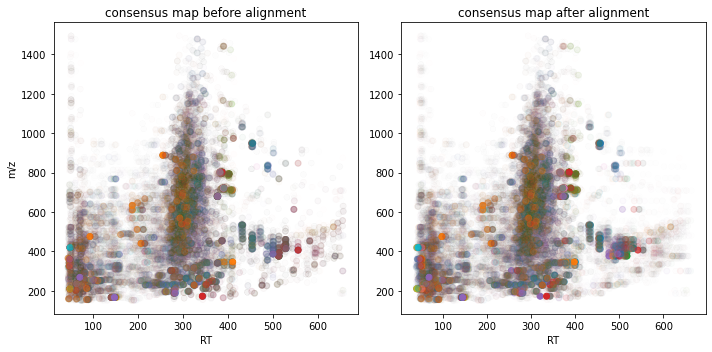

In [17]:
import matplotlib.pyplot as plt
import numpy as np

feature_maps = [feature_maps[ref_index]] + feature_maps[:ref_index] + feature_maps[ref_index+1:]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('consensus map before alignment')
ax.set_ylabel('m/z')
ax.set_xlabel('RT')

# use alpha value to display feature intensity
ax.scatter([f.getRT() for f in feature_maps[0]], [f.getMZ() for f in feature_maps[0]],
            alpha = np.asarray([f.getIntensity() for f in feature_maps[0]])/max([f.getIntensity() for f in feature_maps[0]]))

for fm in feature_maps[1:]:
    ax.scatter([f.getMetaValue('original_RT') for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

ax = fig.add_subplot(1,2,2)
ax.set_title('consensus map after alignment')
ax.set_xlabel('RT')

for fm in feature_maps:
    ax.scatter([f.getRT() for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

fig.tight_layout()
#fig.legend([fmap.getDataProcessing()[0].getMetaValue('parameter: out')[:-11] for fmap in feature_maps], loc = 'lower center')
fig.show()

#### `3) IDMapper` 

Introduce the features to a protein identification file (idXML)- the only way to annotate MS2 spectra for GNPS FBMN  

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/TOPP_IDMapper.html

In [ ]:
print(os.getcwd())
    
input_feature_files = sorted(glob.glob("results/GNPSexport/interim/MapAligned*.featureXML"))
print(input_feature_files)

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

use_centroid_rt= False
use_centroid_mz= True
protein_ids = []
peptide_ids= []

mapper = IDMapper()

input_mzml_files= sorted(glob.glob("results/interim/PCpeak_*.mzML"))
print(input_mzml_files)
for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)

    for fmap in feature_maps:
        if os.path.basename(fmap.getMetaValue('spectra_data')[0].decode()) == os.path.basename(filename):
            peptide_ids = []
            protein_ids = []
            
            mapper.annotate(fmap, peptide_ids, protein_ids, use_centroid_rt, use_centroid_mz, exp)
            print(fmap.getMetaValue('spectra_data')[0].decode())
        featureidx_file = os.path.join("results", "", "GNPSexport", "", "interim", "", 'IDMapper_' + os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
        FeatureXMLFile().store(featureidx_file, fmap)

#### `4) FeatureGroupingAlgorithmKD `

Feature linker aggregates the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [ ]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMapDF()
file_descriptions = consensus_map.getColumnHeaders()

input_feature_files = sorted(glob.glob('results/GNPSexport/interim/IDMapper*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = feature_map.getMetaValue('spectra_data')[0].decode()
    print(file_description.filename)

    file_description.size = feature_map.size()
    # file_description.unique_id = feature_map.getUniqueId() doesn't work on windows
    #print(file_description.unique_id)
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)


Consensus_file= os.path.join("results", "", "GNPSexport", "","interim", "", 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)


# get intensities as a DataFrame
intensities = consensus_map.get_intensity_df()

# get meta data as DataFrame
meta_data = consensus_map.get_metadata_df()[['RT', 'mz', 'charge']]

# you can concatenate these two for a "result" DataFrame
result = pd.concat([meta_data, intensities], axis=1)

# if you don't need labeled index, remove it (and/or save with index = False)
result.reset_index(drop=True, inplace=True)

# store as tsv file
result.to_csv('results/GNPSexport/interim/Consensus.tsv', sep = '\t', index = False)

#### `5) File Filter` 

Remove the features that do not have an MS2 pattern

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FileFilter.html


In [ ]:
input_consensus= "results/GNPSexport/interim/consensus.consensusXML"
cmap = ConsensusMap()
ConsensusXMLFile().load(input_consensus, cmap)
new_map= ConsensusMap(cmap)
new_map.clear(False)
for f in cmap:
    if f.getPeptideIdentifications() !=[]:
        new_map.push_back(f)
        
Consensus_file= os.path.join("results", "", "GNPSexport", "", "interim", "",'filtered' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, new_map)

#### `6) GNPSexport `

The algorithm creates an MGF file with only the MS2 information of all files (introduce mzml files with spaces between them)

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/TOPP_GNPSExport.html

In [ ]:
!resources/OpenMS-2.7.0/bin/GNPSExport -ini resources/GNPSExport.ini -in_cm results/GNPSexport/interim/filtered.consensusXML -in_mzml results/GNPSexport/*.mzML -out results/GNPSexport/MSMS.mgf

#### `7) FeatureQuantificationTable.txt`

Convert the consensusXML file to a txt file for GNPS

In [ ]:
input_consensus= "results/GNPSexport/interim/filtered.consensusXML"
cmap = ConsensusMap()
ConsensusXMLFile().load(input_consensus, cmap)

# get intensities as a DataFrame
intensities = cmap.get_intensity_df()

# get meta data as DataFrame
meta_data = cmap.get_metadata_df()

# you can concatenate these two for a "result" DataFrame
result = pd.concat([meta_data, intensities], axis=1)

# if you don't need labeled index, remove it (and/or save with index = False)
result.reset_index(drop=True, inplace=True)

idx = 0
new_col = "CONSENSUS"  # can be a list, a Series, an array or a scalar   
result.insert(loc=idx, column='#CONSENSUS', value=new_col)   
result= result.rename(columns= {"charge": "charge_cf", "RT": "rt_cf", "mz": "mz_cf", "quality": "quality_cf", "width": "width_cf"})
result= result.drop(["sequence"], axis= 1)
result= result.sort_index(axis=1)
result

In [ ]:
filemeta= cmap.getColumnHeaders()
mapIDs = [k for k in filemeta.keys()]
filename= []
size=[]
label= []
for header in filemeta.values():
    files= header.filename
    sizes= header.size
    labels= header.label
    filename.append(files)
    size.append(sizes)
    label.append(labels)

dict = {'id': mapIDs, 'filename': filename,'label': label,'size': size}
DF= pd.DataFrame(dict)
idx = 0
new_col = "MAP"  # can be a list, a Series, an array or a scalar   
DF.insert(loc=idx, column='#MAP', value=new_col)   
DF["id"] = "intensity_"+ (DF["id"]).astype(str)
cols= result.columns
for col in cols:
    for i, path in enumerate(filename):
        if path== col:
            name= DF["id"][i]
            result.rename(columns={col: name}, inplace=True)

cols = result.columns
preordered = ["#CONSENSUS", "charge_cf", "rt_cf", "mz_cf", "quality_cf", "width_cf"]
new_cols = preordered + [c for c in result.columns if c not in preordered]
new_df = result.reindex(columns=new_cols)
new_df.to_csv('results/GNPSexport/FeatureQuantificationTable.txt', sep = '\t', index = False)
print(new_df)

#### `8) Copy mzML raw files` to the GNPSexport directory (Optional)

In [ ]:
input_mzml_files=glob.glob("results/interim/PCpeak_*.mzML")

for mzml_file in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(mzml_file, exp)
    ff_file = os.path.join("results", "", "GNPSexport", "", os.path.basename(mzml_file)[7:])
    MzMLFile().store(ff_file, exp)